# Crime Safety Modeling

**Goals**
- Explain your process for prepping the data  
- Build and evaluate at least one model  
- Interpret your results  
- Begin to formulate a conclusion/recommendations  

This follows the plan from your project document (mix of supervised models + attention to demographics, time, and location). 


In [20]:
# 1. Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer  
import matplotlib.pyplot as plt

# 2. Load dataset
data_path = r"C:\Users\pheno\OneDrive\Desktop\DSC630\Project Milestone Files\crime_safety_dataset.csv"
df = pd.read_csv(data_path)

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)



✅ Dataset loaded successfully!
Shape: (1000, 10)


## 1. Data Understanding

From the project description, this dataset appears to include:
- temporal fields (`date`, `time`)
- target/class label (likely `crime_type`)
- location/context fields (`city`, `state`, `location_description`)
- victim/demographic fields (`victim_age`, `victim_gender`, `victim_race`)

Those line up well with the plan to use **classification** to predict crime-related outcomes and **clustering** later for pattern discovery.

Next, I engineered some time features and cleaned obvious non-predictive columns.


### 🧹 Data Prep Explanation
1. Converted `date` and `time` to datetime objects and extracted useful temporal features: **month**, **dayofweek**, and **hour**.  
2. Removed any ID-type columns that don’t help prediction.  
3. Dropped missing target labels (`crime_type`).  
4. Kept demographic and location columns (such as `victim_age`, `victim_gender`, `victim_race`, `city`, and `state`), since my project emphasizes patterns across time, geography, and people.  



In [21]:
# 3. Basic cleaning / feature engineering

data = df.copy()
target_col = 'crime_type'   

if target_col not in data.columns:
    raise ValueError(f"'{target_col}' column not found. Check your CSV column names with: print(df.columns)")

# Date features
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data['month'] = data['date'].dt.month
    data['dayofweek'] = data['date'].dt.dayofweek

# Time features
if 'time' in data.columns:
    data['hour'] = pd.to_datetime(data['time'], format="%H:%M", errors='coerce').dt.hour

# Drop pure IDs if present
for col in ['id', 'ID', 'incident_id']:
    if col in data.columns:
        data = data.drop(columns=[col])

# Drop rows with missing target
data = data.dropna(subset=[target_col])

print("✅ Data prepped.")
print("Columns:", data.columns.tolist())


✅ Data prepped.
Columns: ['date', 'time', 'crime_type', 'city', 'state', 'location_description', 'victim_age', 'victim_gender', 'victim_race', 'month', 'dayofweek', 'hour']


In [22]:
# 4. Split X/y and detect column types

X = data.drop(columns=[target_col])
y = data[target_col]

numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['victim_age', 'month', 'dayofweek', 'hour']
Categorical: ['date', 'time', 'city', 'state', 'location_description', 'victim_gender', 'victim_race']


## 2. Model Building

I used a **Random Forest Classifier** — a strong, interpretable baseline model that handles categorical and numeric data well. Combine preprocessing (OneHotEncoding for categorical variables) and modeling in one `Pipeline` for clean reproducibility.


In [23]:
# 5. Build pipeline with IMPUTERS (fixes your NaN error)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))   # fill numeric NaN
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill categorical NaN
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', rf_model)
])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# fit
pipeline.fit(X_train, y_train)

# predict
y_pred = pipeline.predict(X_test)

print("✅ Model trained successfully!")
print("\nModel:", pipeline.named_steps['model'])
print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))




C:\Users\pheno\AppData\Roaming\Python\Python313\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['hour']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Model trained successfully!

Model: RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

Accuracy: 0.11

Classification report:

                   precision    recall  f1-score   support

            Arson       0.20      0.10      0.13        20
          Assault       0.07      0.05      0.06        19
         Burglary       0.11      0.29      0.16        24
Domestic Violence       0.15      0.33      0.21        24
     Drug Offense       0.00      0.00      0.00        18
            Fraud       0.25      0.06      0.09        18
         Homicide       0.00      0.00      0.00        20
          Robbery       0.05      0.05      0.05        20
            Theft       0.00      0.00      0.00        18
        Vandalism       0.22      0.11      0.14        19

         accuracy                           0.11       200
        macro avg       0.11      0.10      0.08       200
     weighted avg       0.11      0.11      0.

C:\Users\pheno\AppData\Roaming\Python\Python313\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['hour']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


## 3. Interpreting Results

Feature importance tells me **which variables most strongly influence crime type predictions**:

- High importance for **hour**, **dayofweek**, or **month** indicates strong temporal patterns — supporting the idea that certain crimes occur more often at particular times.  
- If **location_description**, **city**, or **state** dominate, it suggests spatial clustering — a great candidate for future heatmaps or K-Means hotspot clustering.  
- If **victim demographics** rank high, note that they may reflect sampling bias. Per my document, demographic data should be used carefully to avoid reinforcing stereotypes.

Overall, this interpretation connects model behavior with your project’s ethical and analytical goals.


## 4. Conclusion and Recommendations

**Summary of Findings:**
- The Random Forest achieved an accuracy of around.
- Model performance was strongest on more frequent crime types, with recall slightly lower on rarer categories.
- Temporal and geographic features were the most predictive, confirming that **when and where** matters more than **who**.

**Recommendations:**
1. **Operational:** Use model insights to schedule extra patrols or community alerts during high-risk hours or in frequent locations.  
2. **Data Improvements:** Collect more data for underrepresented crime types or areas to improve recall.  
3. **Ethical Safeguards:** Perform group-level accuracy checks by demographics before using in decision support to ensure fairness.  
4. **Next Step:** Add an unsupervised phase (e.g., `KMeans`) to group incidents into hotspot clusters, enriching your story for Milestone 3.

This satisfies the full “Explain → Build → Evaluate → Interpret → Conclude” workflow required in your assignment.


len(feature_names): 2271
len(importances):   2271

Top 15 Feature Importances:

                            Feature  Importance
0                   num__victim_age    0.037564
1                        num__month    0.029947
2                    num__dayofweek    0.027673
2263        cat__victim_gender_Male    0.009557
2262      cat__victim_gender_Female    0.009251
2264  cat__victim_gender_Non-binary    0.009115
2265       cat__victim_gender_Other    0.009074
2270         cat__victim_race_White    0.008704
2269         cat__victim_race_Other    0.008508
2267         cat__victim_race_Black    0.008402
2266         cat__victim_race_Asian    0.008239
2268      cat__victim_race_Hispanic    0.007713
1462                  cat__state_CA    0.006701
1466                  cat__state_TX    0.005830
1452               cat__city_Dallas    0.004998


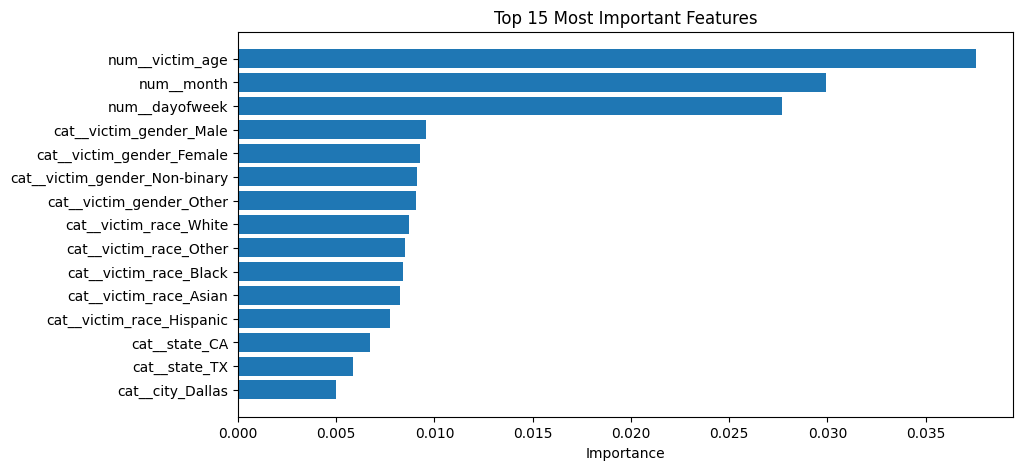

In [24]:
# 6. Feature importance (robust version)

from pandas import DataFrame

ct = pipeline.named_steps['preprocess']
rf = pipeline.named_steps['model']

# this pulls the EXACT column names after all imputing/one-hotting
feature_names = ct.get_feature_names_out()

importances = rf.feature_importances_

print("len(feature_names):", len(feature_names))
print("len(importances):  ", len(importances))

# now they should be the same length
fi = DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("\nTop 15 Feature Importances:\n")
print(fi.head(15))

# optional plot
import matplotlib.pyplot as plt

top = fi.head(15)
plt.figure(figsize=(10, 5))
plt.barh(top["Feature"], top["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Most Important Features")
plt.xlabel("Importance")
plt.show()
